### 1. Preparando o ambiente.

In [2]:
# Instala a biblioteca do Kaggle para podermos interagir com a plataforma.
!pip install kaggle -q

# Importa a biblioteca para fazer o upload de ficheiros.
from google.colab import files

# Solicita o upload do seu ficheiro kaggle.json.
print("Faça o upload do seu ficheiro 'kaggle.json'")
files.upload()

# Configura o diretório e as permissões do ficheiro do Kaggle.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixa os ficheiros da competição "Digit Recognizer".
print("\nBaixando os dados da competição 'Digit Recognizer' do Kaggle...")
!kaggle competitions download -c digit-recognizer

# Descompacta os ficheiros que acabámos de baixar.
print("\nDescompactando os ficheiros...")
!unzip -q digit-recognizer.zip -d ./mnist_dataset

print("\n--- Ambiente Pronto! Os ficheiros do Kaggle foram baixados e descompactados. ---")
print("Ficheiros disponíveis na pasta 'mnist_dataset':")
!ls mnist_dataset

Faça o upload do seu ficheiro 'kaggle.json'


Saving kaggle.json to kaggle.json

Baixando os dados da competição 'Digit Recognizer' do Kaggle...
  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 1.16GB/s]

Descompactando os ficheiros...

--- Ambiente Pronto! Os ficheiros do Kaggle foram baixados e descompactados. ---
Ficheiros disponíveis na pasta 'mnist_dataset':
sample_submission.csv  test.csv  train.csv


### 2. Importação das Bibliotecas
---



In [3]:
# 'os' é usado para interagir com o sistema de ficheiros, como ler nomes de ficheiros.
import os
# 'pandas' é a principal ferramenta para trabalhar com dados em formato de tabela (DataFrames).
import pandas as pd
# 'xml.etree.ElementTree' é usado para ler os ficheiros de anotação que estão no formato XML.
import xml.etree.ElementTree as ET
# 'matplotlib.pyplot' é usado para criar gráficos e visualizações.
import matplotlib.pyplot as plt
# 'cv2' (OpenCV) é uma biblioteca poderosa para manipulação e visualização de imagens.
import cv2
# 'collections.Counter' é uma forma fácil de contar a frequência de itens numa lista.
from collections import Counter

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


### 3. Definição dos Caminhos dos Ficheiros de Dados

In [4]:
# Define o caminho para a pasta onde os nossos dados foram descompactados.
data_folder = 'mnist_dataset'

# Cria o caminho completo para o ficheiro de treino.
train_csv_path = os.path.join(data_folder, 'train.csv')
# Cria o caminho completo para o ficheiro de teste.
test_csv_path = os.path.join(data_folder, 'test.csv')

# Imprime os caminhos para confirmar que estão corretos.
print(f"Caminho do ficheiro de treino: {train_csv_path}")
print(f"Caminho do ficheiro de teste: {test_csv_path}")

Caminho do ficheiro de treino: mnist_dataset/train.csv
Caminho do ficheiro de teste: mnist_dataset/test.csv


### 4. Carregar o Ficheiro de Treino e Explorar a Estrutura

In [5]:
# Usa a função read_csv do Pandas para carregar o nosso ficheiro de treino.
# Esta função lê o ficheiro e o converte num DataFrame.
train_df = pd.read_csv(train_csv_path)

# Imprime as dimensões do nosso DataFrame (número de linhas, número de colunas).
# Devemos ver 42000 linhas (imagens) e 785 colunas (1 para o rótulo + 784 para os píxeis).
print(f"O dataset de treino tem {train_df.shape[0]} linhas e {train_df.shape[1]} colunas.")

# Exibe as 5 primeiras linhas do DataFrame para vermos a estrutura dos dados.
print("\nAmostra dos dados carregados:")
train_df.head()

O dataset de treino tem 42000 linhas e 785 colunas.

Amostra dos dados carregados:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5. Separar Rótulos e Píxeis, e Visualizar um Dígito

A visualizar a primeira imagem do dataset. O rótulo é: 1


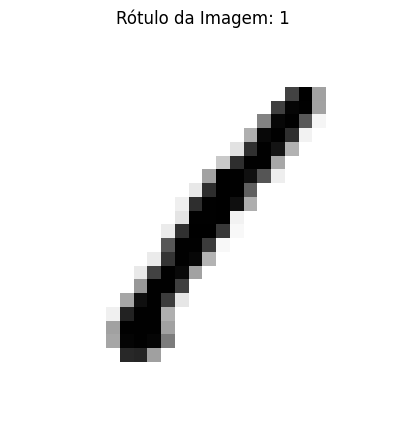

In [6]:
# Separa a coluna 'label' (os nossos y) do resto do DataFrame.
y_train = train_df['label']
# Cria X_train removendo (drop) a coluna 'label'. axis=1 significa que estamos a remover uma coluna.
X_train = train_df.drop('label', axis=1)

# Pega nos dados de píxeis da primeira imagem (índice 0) e converte-os para um array NumPy.
primeira_imagem_pixels = X_train.iloc[0].values

# Remodela o array de 784 píxeis para uma matriz de 28x28.
primeira_imagem_reshape = primeira_imagem_pixels.reshape(28, 28)

# Pega no rótulo correspondente à primeira imagem.
primeiro_rotulo = y_train.iloc[0]

# --- Visualização ---
print(f"A visualizar a primeira imagem do dataset. O rótulo é: {primeiro_rotulo}")

# Cria uma figura para a nossa imagem.
plt.figure(figsize=(5, 5))
# Mostra a imagem remodelada. cmap='gray_r' exibe-a em tons de cinzento invertido (preto sobre branco).
plt.imshow(primeira_imagem_reshape, cmap='gray_r')
# Define o título do nosso gráfico.
plt.title(f'Rótulo da Imagem: {primeiro_rotulo}')
# Esconde os eixos para uma visualização mais limpa.
plt.axis('off')
# Exibe o gráfico.
plt.show()

### 6. Pré-processamento do Conjunto de Dados Completo

In [7]:
# Converte o DataFrame de píxeis para um array NumPy para um processamento mais rápido.
train_images = X_train.values

# 1. Remodela o array de (42000, 784) para (42000, 28, 28, 1).
# O '1' no final representa o canal de cor (1 para tons de cinzento).
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# 2. Normaliza os valores dos píxeis do intervalo [0, 255] para [-1, 1].
# Esta é a normalização padrão para treinar GANs com ativação 'tanh'.
train_images = (train_images - 127.5) / 127.5

# Define o tamanho do buffer para baralhar os dados e o tamanho de cada lote.
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Cria um objeto tf.data.Dataset a partir dos nossos arrays de imagens.
# Isto permite um carregamento de dados muito eficiente.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Imprime uma confirmação
print("Pré-processamento concluído com sucesso!")
print(f"Os dados estão agora em lotes de {BATCH_SIZE} imagens.")
print("Formato de um lote de imagens:", next(iter(train_dataset)).shape)

Pré-processamento concluído com sucesso!
Os dados estão agora em lotes de 256 imagens.
Formato de um lote de imagens: (256, 28, 28, 1)


In [9]:
# Define o nome do ficheiro de saída. A extensão .npy é o formato padrão do NumPy.
output_filename = 'mnist_processed_images.npy'

# Usa a função np.save para guardar o nosso array de imagens processadas num ficheiro.
np.save(output_filename, train_images)

# Imprime uma mensagem de confirmação.
print(f"O conjunto de dados de treino processado foi guardado com sucesso em: '{output_filename}'")

O conjunto de dados de treino processado foi guardado com sucesso em: 'mnist_processed_images.npy'
